# Playing with the FERC small generators table

This notebook takes the header rows interspersed throughout the data and turns them into actual headers rather than rows with NAN values. In the final output, the columns `manual_map` refers to the column
previously called `plant_type` that was manually mapped by zane. The column called `headers` is the new
column that maps these values programatically.

To compare the programatic mapping against the manual mapping, I created a dictionary that mirrors the type of fuel labels used by Zane in the manual map. You can decide whether to use this one (for compariative
purposes) or another generic one for other (rmi) purposes.

The final `assign_headers_all()` function allows you to not `drop_headers` if you want. This is a good way to check the efficacy of the programatic header mapping. Otherwise, it will automatically remove all of the
header rows from the data along with any of the support columns created along the way.

## Setup

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
# Standard libraries
import logging
import sys
import os
import pathlib
import random

# 3rd party libraries
import geopandas as gpd
import dask.dataframe as dd
from dask.distributed import Client
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report
import sqlalchemy as sa
#import pickle

# Local libraries
import pudl
#from pudl.analysis.fill_ferc1_fuel_gaps import *
#from pudl.analysis.flag_ferc1_totals import *

# Enable viewing of logging outputs
logger=logging.getLogger()
logger.setLevel(logging.INFO)
handler = logging.StreamHandler(stream=sys.stdout)
formatter = logging.Formatter('%(message)s')
handler.setFormatter(formatter)
logger.handlers = [handler]

# Display settings
sns.set()
%matplotlib inline
mpl.rcParams['figure.dpi'] = 75
pd.options.display.max_columns = 100
pd.options.display.max_rows = 100

In [3]:
# Establish connection to pudl database
pudl_settings = pudl.workspace.setup.get_defaults()
pudl_engine = sa.create_engine(pudl_settings['pudl_db'])
pudl_out = pudl.output.pudltabl.PudlTabl(
    pudl_engine=pudl_engine,
    freq='AS'
)

ferc_engine = sa.create_engine(pudl_settings['ferc1_db'])

In [4]:
small_plants_raw = pd.read_sql("f1_gnrt_plant", ferc_engine)
small_plants = pudl_out.plants_small_ferc1()#.dropna(subset=['plant_name_ferc1'])

In [5]:
# View random utility groups! (thanks, Trenton)
def view_random_utility(df):
    df = df.reset_index(drop=True)
    util_groups = df.groupby(['utility_id_ferc1'])
    random_utility = random.choice(list(util_groups.groups.keys()))
    return df.iloc[util_groups.groups[random_utility]]

## Use Zane's transformations without dropping the NA rows

In [6]:
# Here we create a fake raw dfs dictionary with just the small plants df to run it through
# Zane's existing transform feature.
fake_dict = {'plants_small_ferc1': small_plants_raw}
new_dict = {}
small_plants_dict = pudl.transform.ferc1.plants_small(fake_dict, new_dict)
small_plants_out = small_plants_dict['plants_small_ferc1']

# drop rows with no plant name because we can't use that
small_plants_out = small_plants_out.dropna(subset=['plant_name_ferc1'])

/Users/aesharpe/miniconda3/envs/pudl-dev/lib/python3.9/site-packages/openpyxl/worksheet/_reader.py:312: UserWarning: Unknown extension is not supported and will be removed
  warn(msg)


## Constants

In [19]:
# If these columns are nan, we can assume it is either a header row or isn't useful
nan_cols = ['construction_year', 'net_generation_mwh', 'total_cost_of_plant', 'capex_per_mw', 'opex_total', 
            'opex_fuel', 'opex_maintenance', 'fuel_cost_per_mmbtu']

# If a potential header column has these strings, it's probably a useful header
header_strings = ['hydro', 'hyrdo', 'internal', 'wind', 'solar', 'gas', 'diesel', 'diesal', 
                  'steam', 'other', 'combustion', 'combustine', 'fuel cell', 'hydraulic', 
                  'waste', 'landfill', 'photovoltaic', 'nuclear', 'oil', 'renewable', 
                  'facilities', 'combined cycle']

# If a potential header has these strings, it is not a header...
exclude = ['#', '\*', 'pg', 'solargenix', 'solargennix', '\@', 'rockton', 'albany steam']

# ...unless it also has one of these strings
exceptions = ['hydro plants: licensed proj. no.', 'hydro license no.', 
              'hydro: license no.', 'hydro plants: licensed proj no.']

# What we will rename the headers once we remove them as rows 
new_header_labels = {
    'hydroelectric': ['hydro', 'hyrdo'],
    'internal combustion': ['internal', 'interal', 'international combustion'],
    'combustion turbine': ['combustion turbine'],
    'combined cycle': ['combined cycle'],
    'gas turbine': ['gas'],
    'petroleum liquids': ['oil', 'diesel', 'diesal'],
    'solar': ['solar', 'photovoltaic'],
    'wind': ['wind'],
    'geothermal': ['geothermal'],
    'waste': ['waste', 'landfill'],
    'steam': ['steam'],
    'nuclear': ['nuclear'],
    'fuel_cell': ['fuel cell']
}

# Header names that match the one's that zane used in his manual mapping (so we can 
# compare processes)
zane_header_labels = {
    'solar_pv': ['solar', 'photovoltaic'],
    'wind': ['wind'],
    'hydro': ['hydro', 'hyrdo'],
    'internal_combustion': ['internal', 'interal', 'international combustion', ],
    'combustion_turbine': ['combustion turbine', 'combustine turbine'],
    'combined_cycle': ['combined cycle'],
    'diesel_turbine': ['oil', 'diesel', 'diesal'],
    'gas_turbine': ['gas'],
    'geothermal': ['geothermal'],
    'waste_heat': ['waste', 'landfill'],
    'steam_heat': ['steam'],
    'nuclear': ['nuclear'],
    'fuel_cell': ['fuel cell']
}

## Get rid of rows we know we won't need

* Utilities with all NA rows
* Rows that are just dashes
* Clumps of notes or bad data <---- need to add this up here (is below in the header extraction for now)

### Show Proof / Explanation of Changes

In [17]:
test_nan_cols = (
    small_plants_out
    .groupby('utility_id_ferc1').filter(lambda x: x[nan_cols].isna().all().all())
    ['plant_name_ferc1'].value_counts())

test_dash_rows = small_plants_out[small_plants_out['plant_name_ferc1'].str.contains('---')].plant_name_ferc1.value_counts()
test_string_na_rows = small_plants_out[small_plants_out['plant_name_ferc1'].isin(['', 'none', 'na', 'n/a', 'not applicable'])].plant_name_ferc1.value_counts()

#print('**TEST DROP UTILITYS WITH ALL NAN ROWS**\n\n',test_nan_cols,'\n\n')
#print('**TEST DROP ROW DASHES **\n\n',test_dash_rows) # This shows that we can safely remove rows with three or more dashes
#print('**TEST DROP STRING NA **\n\n',test_string_na_rows)

### Execute Changes

In [69]:
# Remove utilities with all NAN rows because these won't contain anything meaningful
# spc = small_plants_clean
spc = (
    small_plants_out
    .groupby('utility_id_ferc1').filter(lambda x: ~x[nan_cols].isna().all().all())
)
# Show what was removed
#print('REMOVED NAN VALUES: \n')
#pd.concat([small_plants_out,spc]).drop_duplicates(keep=False)[nan_cols].info()
#print('\n')

# Remove rows with ----------or '' for names
spc2 = spc[~spc['plant_name_ferc1'].str.contains('---')].copy()
spc3 = spc2[~spc2['plant_name_ferc1'].isin(['', 'none', 'na', 'n/a', 'not applicable'])].reset_index(drop=True)

# Show what was removed
#print('REMOVED NAN NAMES:\n', pd.concat([spc, spc3]).drop_duplicates(keep=False).plant_name_ferc1.value_counts(), '\n')

# Show total rows removed
#print(f'TOTAL ROWS REMOVED: {len(small_plants_out) - len(spc3)} rows. Current row total: {len(spc3)}')

## Make column for FERC license numbers

### Show Proof/Explanation of Changes

In [368]:
# Data segements
test = spc3.copy()

digit_length_2 = test.plant_name_ferc1.str.contains(r'\b\d{2}\b', regex=True)
digit_length_3_plus = test.plant_name_ferc1.str.contains(r'\d{3}', regex=True)
obvious_license = test.plant_name_ferc1.str.contains('no\.|license|ferc|project', regex=True)
not_license = test.plant_name_ferc1.str.contains('page|pg|\$|wind|nonutility|units|surrendered', regex=True)
exceptions = test.plant_name_ferc1.str.contains('tomahawk|otter rapids|wausau|alexander|hooksett|north umpqua', regex=True)
not_hydro = ~test.plant_type.isin(['hydro', np.nan])

In [285]:
# A quick scan shows us that there is only one 2 digit numbers that is probably a FERC license: potter valley ferc no. 77'.
# When you change that digit length to 3, it looks like more licences are captured.

#print('Plant names with two digit numbers and probably license indicators')
#test[digit_length_2 & obvious_license].plant_name_ferc1.unique().tolist()

# Even when it's not obviously a FERC license number, it still looks like the majority of 3+ digit numbers refer
# to FERC licenses. The exception is usually for year values, page numbers, dollar values, or wind turbines. 
# It's unlikely that a plant (besides wind) will have units in the 3 digits which is why these numbers may be 
# reasonably assumed to be FERC license values.

#print('Plant names with three+ digit numbers and no obvious license indicators')
#test[digit_length_3_plus & ~obvious_license].plant_name_ferc1.unique().tolist()

In [369]:
# Assuming that we start by extracting all numbers 3 digits and up, lets identify the NON FERC license 
# values that got mixed in and remove them. First, we know that only hydro plants have a ferc license, 
# so lets not bother with anything that isn't that or NA
test['ferc_license'] = test.plant_name_ferc1.str.extract(r'(\d{3,})').astype('float').astype('Int64')
test.loc[not_hydro, 'ferc_license'] = pd.NA
extracted_license = test.ferc_license.notna()

In [370]:
# Now, lets look at some key words that indicate a row is definitely not a FERC license
test[extracted_license & not_license].plant_name_ferc1.unique().tolist()

['included on pages 402, 403, and 403a',
 '(continued on page 410-1)',
 'see notes on page 411-2 thru 411-5.',
 '** license surrendered august 1982',
 '* license surrendered december 1981.',
 '* license surrendered december 1981',
 'was sold on march 20, 1996. see ferc page',
 '108, number 3 and pages 206-207, line no.86',
 '* license surrendered august 1982',
 '** license surrendered december 1981',
 '(b) included deferred fuel of $1,268',
 '(c) included deferred fuel of $26,532',
 'with east hampton gas turbine page 403-b',
 'see note 3, page 109.',
 'with east hampton gas turbine on pg 403-b',
 'sold during the year; see note 3, page 109',
 'with e hampton gas turbine on pg 403.2',
 'sold in 1999 - see page 402',
 'pg. 403.2',
 'with e. hampton gas turbine on page 403.2.',
 '121, nonutility property.',
 'nonutility property and account 122,',
 '* license surrendered august 1982.',
 '** license surrendered december 1981.',
 'moline conventional hydro (4 units @ 900kw each)',
 'intrep

In [327]:
# Feeling good about that, we'll go ahead and remove those from the ferc_license column.
test.loc[extracted_license & not_license, 'ferc_license'] = np.nan
extracted_license = test.ferc_license.notna()

# Now we'll tackle YEARS. It looks like there are some occasions where "obvious" license terms are associated
# with years rather than actual license values. Any time the entry contains the phrase "note, surrender, or page" it's
# not a FERC license. Non-obvious licenses that are also year-esc are spot on except for otter rapids, tomahawk,
# alexander, and wausau..."

year_vs_num = (test['ferc_license'] > 1900) & (test['ferc_license'] < 2050)
test[extracted_license & year_vs_num & ~obvious_license & ~exceptions].plant_name_ferc1.unique().tolist()

[]

In [311]:
test.loc[extracted_license & year_vs_num & ~obvious_license & ~exceptions, 'ferc_license'] = np.nan
extracted_license = test.ferc_license.notna()

# Now lets take a looks at our left-over licenses that aren't obvious....looks pretty good!
test[extracted_license & ~obvious_license].plant_name_ferc1.unique().tolist()
test[extracted_license & obvious_license].plant_name_ferc1.unique().tolist()

['(a) project #2438',
 '(b) project #2738',
 '(c) project #2835',
 '(d) project #2852',
 'allen falls (project no. 10462)',
 'bakers falls (project no. 2482)',
 'baldwinsville (project no. 5217)',
 'belfort (project no. 2645)',
 'black river (project no. 2569)',
 'chasm (project no. 7320)',
 'eagle (project no. 2645)',
 'east norfolk (project no. 2330)',
 'eel weir (project no. 2713)',
 'effley (project no. 2645)',
 'niagara-project #2466',
 'buck-project #2514',
 'license project: 2069',
 'medway license #2666',
 'milford license #2534',
 'veazie license #2403',
 'ellsworth license #2727',
 'howland license #2721',
 'stillwater license #2712',
 'orono license #2710',
 'ferc licensed project no. 2380',
 'a project # 2090',
 'b project # 2531',
 'c project # 2674',
 'd project # 2879',
 'elkart (project no. 2651)',
 'buchanan (project no. 2551)',
 'twin branch (project no. 2579)',
 'constantine (project no. 10661)',
 'mottville (project no.401)',
 'knife falls ferc project no. 2360',
 '

### Execute Changes

In [371]:
def add_ferc_lic_col(df):

    """Extract FERC license number from plant_name_ferc1 and make new column.
    
    Many of FERC license numbers are embedded in the plant_name_ferc1 field. This function
    Extracts those license numbers and puts them in a new column.
    
    """
    # Extract all numbers greater than 2 digits from plant_name_ferc1 and put then in a new column as integers.
    # Rename manually collected FERC id column to reflect that.
    df = (
        df.assign(
            ferc_license=lambda x: x.plant_name_ferc1.str.extract('(\d{3,})').astype('float').astype('Int64'),
            ferc_license_id=lambda x: x.ferc_license_id.astype('Int64'))
        .rename(columns={'ferc_license_id': 'ferc_license_manual'}))
    
    # Not all of these 3+ digit numbers are FERC licenses. Some are dates, dollar amounts, page numbers, or numbers
    # of wind turbines. These next distinctions help to weed out the non-licesnse values and keep the good ones.
    obvious_license = df.plant_name_ferc1.str.contains('no\.|license|ferc|project', regex=True)
    not_license = df.plant_name_ferc1.str.contains('page|pg|\$|wind|nonutility|units|surrendered', regex=True)
    exceptions = df.plant_name_ferc1.str.contains('tomahawk|otter rapids|wausau|alexander|hooksett|north umpqua', regex=True)
    year_vs_num = (df['ferc_license'] > 1900) & (df['ferc_license'] < 2050)
    not_hydro = ~df.plant_type.isin(['hydro', np.nan])
    extracted_license = df.ferc_license.notna()
    
    # Replace all the non-license numbers with nan
    df.loc[extracted_license & not_hydro, 'ferc_license'] = pd.NA
    extracted_license = df.ferc_license.notna() # reset
    df.loc[extracted_license & not_license, 'ferc_license'] = pd.NA
    extracted_license = df.ferc_license.notna() #reset
    df.loc[extracted_license & year_vs_num & ~obvious_license & ~exceptions, 'ferc_license'] = pd.NA

    df['ferc_license'] = df.ferc_license.astype('Int64') # figure out how not to do this twice....
    
    return df

In [361]:
spc4 = add_ferc_lic_col(spc3)

In [362]:
print('manually added licenses:', len(spc4[spc4['ferc_license_manual'].notna()]))
print('programatically scraped licenses:', len(spc4[spc4['ferc_license'].notna()]))

manually added licenses: 1842
programatically scraped licenses: 4275


In [363]:
# Proof -- four mapped license records don't match my programatic records, but I think mine are right:
only_manual = spc4['ferc_license_manual'].notna()
not_matching_ids = spc4['ferc_license_manual'] != spc4['ferc_license']
dd = spc4[only_manual & not_matching_ids][['plant_name_ferc1', 'report_year', 'ferc_license_manual', 'ferc_license']]

print(dd)

                      plant_name_ferc1  report_year  ferc_license_manual  \
8224        rochester station #160 (3)         2004                 2596   
8760        rochester station #160 (3)         2005                 2596   
9324   rochester station #160 (note 3)         2006                 2596   
10004  rochester station #160 (note 3)         2007                 2596   

       ferc_license  
8224            160  
8760            160  
9324            160  
10004           160  


## Flag total rows

In [372]:
spc4.insert(3, 'is_total', False)
spc4.loc[spc4['plant_name_ferc1'].str.contains('total'), 'is_total'] = True

In [374]:
# View these total rows...
spc4[spc4['is_total']].plant_name_ferc1.value_counts()

total                                               199
total hydro                                          47
total hydro (small plants)                           26
total internal combustion                            26
total solar operation/maintenance                    20
(amounts are for the total of all 28 units)          20
total south dakota                                   17
(amounts are for the total of all 4 units)           16
grand total                                          16
total yellowstone                                    16
(amounts are for the total of all 122 units)         15
(amounts are for the total of all 66 units)          14
total molokai                                        14
(amounts are for the total of all 100 units)         13
(amounts are for the total of all 102 units)         12
(amounts are for the total of all 145 units)         12
(amounts are for the total of all 76 units)          12
(amounts are for the total of all 50 units)     

## Flag possible headers

In [376]:
# If a potential header column has these strings, it's probably a useful header
header_strings = ['hydro', 'hyrdo', 'internal', 'wind', 'solar', 'gas', 'diesel', 'diesal', 
                  'steam', 'other', 'combustion', 'combustine', 'fuel cell', 'hydraulic', 
                  'waste', 'landfill', 'photovoltaic', 'nuclear', 'oil', 'renewable', 
                  'facilities', 'combined cycle']

# If a potential header has these strings, it is not a header...
exclude = ['#', '\*', 'pg', 'solargenix', 'solargennix', '\@', 'rockton', 'albany steam']

# ...unless it also has one of these strings
exceptions = ['hydro plants: licensed proj. no.', 'hydro license no.', 
              'hydro: license no.', 'hydro plants: licensed proj no.']

# What we will rename the headers once we remove them as rows 
new_header_labels = {
    'hydroelectric': ['hydro', 'hyrdo'],
    'internal combustion': ['internal', 'interal', 'international combustion'],
    'combustion turbine': ['combustion turbine'],
    'combined cycle': ['combined cycle'],
    'gas turbine': ['gas'],
    'petroleum liquids': ['oil', 'diesel', 'diesal'],
    'solar': ['solar', 'photovoltaic'],
    'wind': ['wind'],
    'geothermal': ['geothermal'],
    'waste': ['waste', 'landfill'],
    'steam': ['steam'],
    'nuclear': ['nuclear'],
    'fuel_cell': ['fuel cell']
}

# Header names that match the one's that zane used in his manual mapping (so we can 
# compare processes)
zane_header_labels = {
    'solar_pv': ['solar', 'photovoltaic'],
    'wind': ['wind'],
    'hydro': ['hydro', 'hyrdo'],
    'internal_combustion': ['internal', 'interal', 'international combustion', ],
    'combustion_turbine': ['combustion turbine', 'combustine turbine'],
    'combined_cycle': ['combined cycle'],
    'diesel_turbine': ['oil', 'diesel', 'diesal'],
    'gas_turbine': ['gas'],
    'geothermal': ['geothermal'],
    'waste_heat': ['waste', 'landfill'],
    'steam_heat': ['steam'],
    'nuclear': ['nuclear'],
    'fuel_cell': ['fuel cell']
}

In [377]:
# Add some new columns
spc4.insert(3, 'is_header', False)
spc4.insert(3, 'header_type', np.nan)

# Label possible header rows (based on the nan cols specified above)
spc4.loc[spc4.filter(nan_cols).isna().all(1), 'is_header'] = True

# Label good header rows (based on whether they contain key strings)
is_header = spc4['is_header']
is_good_header = spc4['plant_name_ferc1'].str.contains('|'.join(header_strings))
not_bad = ~spc4['plant_name_ferc1'].str.contains('|'.join(exclude))

spc4.loc[is_header & is_good_header & not_bad, 'header_type'] = 'good_header'
spc4.loc[spc4['plant_name_ferc1'].isin(exceptions), 'header_type'] = 'good_header'

In [383]:
# Take a look:
spc4[spc4['header_type'] == 'good_header'].plant_name_ferc1.sort_values().unique().tolist()

['(1) the dixon hydro electric generating facility',
 '(6) excludes portion allocated to other water',
 '(6) milwaukee county is a steam utility plant',
 '(7) montfort wind farm was purchased dec. 2012.',
 '(hydroelectric facility)',
 'a - hydro license project no. 2315.',
 'a-hydro license project no. 2315',
 'a-internal combustion unit',
 'additional hydro plant',
 'auke bay internal combustion',
 'auke bay internal combustion:',
 'available for specific diesel unit.',
 'available for specific diesel units.',
 'b-combustion turbine unit',
 'black start diesel units',
 'black start diesel units:',
 'combined cycle plant:',
 'combined with e. hampton gas turbine on',
 'combustine turbine',
 'combustion turbine',
 'conemaugh - internal combustion',
 'cost of plant for diesel plants is included in',
 'diesal',
 'diesel',
 'diesel generators',
 'diesel plant',
 'diesel plants',
 'diesel plants:',
 'diesel:',
 'dinner lake gas',
 'fuel cell',
 'fuel cell:',
 'gas plant',
 'gas turbine',
 '

## Get rid of large clumps of notes or bad headers

In [48]:
from pudl.analysis.fill_ferc1_fuel_gaps import create_groups

def get_header_clumps_all(df):
    """
    Remove clumps of consecutive rows flagged as possible headers.
    
    FERC has lots of note rows that are not headers but are also not useful for analysis.
    This function looks for rows flagged as possible headers (based on NAN values) and checks to
    see if there are multiple in a row. A header row is (usually) defined as a row with NAN values
    followed by rows without NAN values, so when there are more than one clumped together they are
    likely either notes or not helpful.
    
    Sometimes note clumps will end with a meaningful header. This function also checks for this and will
    unclump any headers at the bottom of clumps. There is one exception to this case which is a header that 
    is followed by a plant that had no values reported... Unfortunately I haven't built a work around,
    but hopefully there aren't very many of these. Currently, that header and plant will be categorized
    as clumps and removed.
    
    """
    util_groups = df.groupby(['utility_id_ferc1', 'report_year'])
    
    def get_header_clumps(util_year_group):
        
        # Create mini groups that count pockets of true and false for each utility and year
        # create_groups() is a function from the fill_ferc1_fuel_gaps module-- basically what
        # it does is create a df where each row represents a clump of adjecent, equal values for
        # a given column. Ex: a column of True, True, True, False, True, False, False, will
        # appear as True, False, True, False with value counts for each
        group, header_count = create_groups(util_year_group, 'is_header')
        
        # These are used later to enable exceptions
        max_idx_val = header_count.index.max()
        max_df_val = util_year_group.index.max()
        
        # Create a list of the index values that comprise each of the header clumps
        # It's only considered a clump if it is greater than 1.
        idx_list = list(header_count[
            (header_count['fuel']) & (header_count['val_count'] > 1)].index)
        
        # If the last row is not a clump (i.e. there is just one value) but it is a header (i.e. has nan values)
        # then also include it in the index values to be flagged because it might be a one-liner note. And
        # because it is at the bottom there is no chance it can actually be a useful header because there are
        # no value rows below it.
        last_row = header_count.tail(1)
        if (last_row['fuel'].item()) & (last_row['val_count'].item()==1):
            idx_list = idx_list + list(last_row.index)
        # If there are any clumped/end headers:
        if idx_list:
            for idx in idx_list:
                # Check to see if last clump bit is not a header... sometimes you might find a clump of
                # notes FOLLOWED by a useful header. This next bit will check the last row in each of
                # the identified clumps and "unclump" it if it looks like a valid header. We only need
                # to check clumps that fall in the middle because, as previously mentioned, the last row
                # cannot contain any meaningful header information because there are no values below it.
                idx_range = group.groups[idx+1]
                is_middle_clump = group.groups[idx+1].max() < max_df_val
                is_good_header = util_year_group.loc[
                    util_year_group.index.isin(group.groups[idx+1])].tail(1)['plant_name_original'].str.contains('|'.join(header_strings)).all()  #.isin(header_strings).all()
                # If the clump is in the middle and the last row looks like a header, then drop it from the idx range
                if is_middle_clump & is_good_header:
                    idx_range = [x for x in idx_range if x != idx_range.max()]
                # Label the clump as a clump
                util_year_group.loc[
                    util_year_group.index.isin(idx_range), 'header_type'] = 'clump'
        return util_year_group
    
    return util_groups.apply(lambda x: get_header_clumps(x))

In [49]:
header_clumps = get_header_clumps_all(spc4)

In [51]:
header_clumps['header_type'].unique()

array(['good_header', nan, 'clump'], dtype=object)

In [53]:
# List of things that don't make the cut as headers after removing all the notes rows
bad_headers = list(
    header_clumps[
        (header_clumps['is_header']) 
        & (header_clumps['header_type'].isna())].plant_name_original.unique())

bad_headers.sort()
bad_headers

['(amounts are for the total of all 100 units)',
 '(amounts are for the total of all 102 units)',
 '(amounts are for the total of all 107 units)',
 '(amounts are for the total of all 171 units)',
 '(amounts are for the total of all 193 units)',
 '(amounts are for the total of all 214 units)',
 '(amounts are for the total of all 28 units)',
 '(amounts are for the total of all 4 units)',
 '(amounts are for the total of all 44 units)',
 '(amounts are for the total of all 50 units)',
 '(amounts are for the total of all 51 units)',
 '(amounts are for the total of all 52 units)',
 '(amounts are for the total of all 60 units)',
 '(amounts are for the total of all 64 units)',
 '(amounts are for the total of all 66 units)',
 '(amounts are for the total of all 76 units)',
 '(amounts are for the total of all 84 units)',
 '(amounts are for the total of all 87 units)',
 '(emergency standby units)',
 '* generation is recorded as company use',
 '* license surrendered august 1982.',
 '* mammoth pool',

In [21]:
# List of acceptable headers
good_headers = list(
    header_clumps[
        header_clumps['header_type']=='good_header'].plant_name_original.unique())
good_headers.sort()
good_headers

['additional hydro plant',
 'auke bay internal combustion',
 'auke bay internal combustion:',
 'black start diesel units',
 'black start diesel units:',
 'combined cycle plant:',
 'combustine turbine',
 'combustion turbine',
 'diesal',
 'diesel',
 'diesel plant',
 'diesel plants',
 'diesel plants:',
 'diesel:',
 'dinner lake gas',
 'fuel cell',
 'fuel cell:',
 'gas plant',
 'gas turbine',
 'gas turbine plant',
 'gas turbine plants',
 'gas turbine:',
 'gas turbines',
 'gas turbines:',
 'gold creek internal combustion:',
 'hydraulic',
 'hydraulic (1):',
 'hydraulic:',
 'hydro',
 'hydro -',
 'hydro : licensed proj. no.',
 'hydro electric',
 'hydro lic project no.',
 'hydro lic. project no.',
 'hydro license',
 'hydro license no.',
 'hydro plant:',
 'hydro plants',
 'hydro plants:',
 'hydro plants: licensed proj no.',
 'hydro plants: licensed proj. no.',
 'hydro-electric',
 'hydro:',
 'hydro: lic project no.',
 'hydro: lic. project no.',
 'hydro: license no.',
 'hydroelectric',
 'hydroelec

## Identify and label plant groups for true headers...

In [22]:
def assign_headers_all(df, header_labels, drop_headers=True):
    """
    Group the data by header and create header column.
    
    This function gets rid of the clumps and turns the header row into a header column.
    It does this by grouping the data into groupby object based on the presence of "good"
    header columns throughout the data. Each group begins with a good header and ends
    right before the next one, if applicable. This doesn't *always* work (see utility id
    120 year 2011) but that's usually because of bad reporting not a program glitch.
    
    The function also cleans up the header names.
    
    remove_headers may be switched to false if you want to double check how well
    the program maps headers / whether there are any glitches.
    
    """
    # Start by dropping the clumps
    df = df.drop(df[(df['is_header']) & (df['header_type']=='clump')].index).reset_index(drop=True)
    
    # Turn good headers into booleans
    df['is_good_header'] = False
    df.loc[df['header_type']=='good_header', 'is_good_header'] = True
    
    # Clean up header names - made a new col just to preserve any of the original names
    for tech in header_labels:
        is_good_header = df['is_good_header']
        has_tech = df['plant_name_original'].str.contains('|'.join(header_labels[tech]))
        df.loc[is_good_header & has_tech, 'header_prep_clean'] = tech
            
    # Note likely header rows that haven't been categorized
    not_mapped = df[(df['header_prep_clean'].isna()) & (df['is_good_header'])]['plant_name_original'].unique()
    print('likely headers that have not been mapped:', not_mapped)
    
    # Make groups based on the year and whether there is a header
    header_groups = df.groupby(['utility_id_ferc1', 'report_year', df['is_good_header'].cumsum()])

    # Assign that header to the rows that follow
    def assign_header(header_group):
        header_value = header_group[header_group['is_good_header']]['header_prep_clean']
        if not header_value.empty:
            header_group.insert(3, 'header', header_value.item())
        return header_group

    out_df = header_groups.apply(lambda x: assign_header(x))
    
    # Now we can remove the useless rows and headers
    if drop_headers:
        out_df = (
            out_df.dropna(subset=nan_cols, how='all')
            .drop(columns=['is_header', 'header_type', 'is_good_header', 'header_prep_clean'], axis=1))
        
    
    return out_df

In [23]:
def add_obvious_headers(df, chosen_label, show_assumptions=False):
    """Add plant type when included in plant name.
    
    When plants have their tech type embeded in their name it's fairly safe to 
    assume that that is also the given plant type. This isn't always the case,
    however, and this function also accounts for some of those outliers.
    
    """
    # wierd plants that have two fuel/plant types in their name.
    exceptions = {
        np.nan: ['windsor rd', 'gaston', 'sc-etwind'],
        'solar_pv': ['las vegas solar'],
        'gas_turbine': ['solar centaur']}
    
    if show_assumptions:
        for tech in chosen_label:
            print('')
            print('header: ', tech)
            print('qualifying strings: ', chosen_label[tech])
            print('strings in the data:')
            print(df[df['plant_name_original'].str.contains(
                '|'.join(chosen_label[tech]))].plant_name_original.sort_values().unique())
        for tech in exceptions:
            print('the following exceptions are made for plants that do not fit into these criteria:')
            print('header: ', tech)
            print('qualifying strings: ', exceptions[tech])
    
    # label all "obvious" plant types
    for tech in chosen_label:
        df.loc[df['plant_name_original'].str.contains(
                '|'.join(chosen_label[tech])), 'header'] = tech
    
    # fix ones that aren't so "obvious"
    for tech in exceptions:
        df.loc[df['plant_name_original'].str.contains(
            '|'.join(exceptions[tech])), 'header'] = tech        
    
    return df

In [24]:
def final_touches(df, chosen_labels):
    """Miscellaneous tasks to complete header compilation for RMI."""
    
    # Label plants with plant type in their name
    df = add_obvious_headers(df, chosen_labels)
    
    # Mark any plant with a license number as hydro
    df.loc[df['ferc_license'].notna(), 'header'] = 'hydro'
    
    # Move the plant type col closer to the front for visual comparison
    df.insert(3, 'manual_map', df.plant_type)

    # Create a new column that merges zane's manual labeling with my programatic labeling
    df.insert(3, 'header_manual_code_combo', df.header.fillna(df.manual_map))
    
    print('')
    print('header matches manual plant type:', len(df[df['header'] == df['plant_type']]))
    print('total manual plant types:', len(df[df['manual_map'].notna()]))
    print('total headers mapped:', len(df[df['header'].notna()]))
    print('total headers with manual:', len(df[df['header_manual_code_combo'].notna()]))
    print('total rows:', len(df))
    print('')
    
    return df

In [25]:
chosen_labels = zane_header_labels

# Assign headers - drop all header columns
assigned_headers_drop = (
    assign_headers_all(header_clumps, chosen_labels)
    .pipe(final_touches, chosen_labels))

assigned_headers = (
    assign_headers_all(header_clumps, chosen_labels, drop_headers=False)
    .pipe(final_touches, chosen_labels))

likely headers that have not been mapped: ['hydraulic' 'other:' 'other production:' 'lewiston canal facilities:'
 'other' 'hydraulic (1):' 'hydraulic:'
 'other general ops. supervision & engineering' 'other-leased:'
 'renewables' 'renewables:']

header matches manual plant type: 4895
total manual plant types: 6526
total headers mapped: 12784
total headers with manual: 13729
total rows: 14953

likely headers that have not been mapped: ['hydraulic' 'other:' 'other production:' 'lewiston canal facilities:'
 'other' 'hydraulic (1):' 'hydraulic:'
 'other general ops. supervision & engineering' 'other-leased:'
 'renewables' 'renewables:']

header matches manual plant type: 4902
total manual plant types: 6533
total headers mapped: 14808
total headers with manual: 15753
total rows: 17252



## Compare manual map to programatic...

In [26]:
test = assigned_headers_drop.copy()
test.loc[:, 'header'] = test['header'].fillna('NAN')
test.loc[:,'manual_map'] = test['manual_map'].fillna('NAN')

categories = set(test['manual_map'].unique()) | set(test['header'].unique())
categories = sorted(list(categories))

In [27]:
# rows (indicated with suffix _manual) are True
# columns (_header) are modeled
conf_matrix = pd.DataFrame(confusion_matrix(test['manual_map'], test['header'], labels=categories),
                           columns=[label + '_header' for label in categories],
                           index=[label + '_manual' for label in categories])

def highlight_diagonal(df, color='lightgreen'):
    """ highlight diagonal elements of a dataframe. Useful for symmetric matrices like confusion and correlation matrices"""
    def highlight_diag(df):
        a = np.full(df.shape, '', dtype='<U24')
        np.fill_diagonal(a, f'background-color: {color}')
        return pd.DataFrame(a, index=df.index, columns=df.columns)
    return df.style.apply(highlight_diag, axis=None)

highlight_diagonal(conf_matrix)

,NAN_header,coal_header,cogen_header,combined_cycle_header,combustion_turbine_header,diesel_turbine_header,fuel_cell_header,gas_turbine_header,hydro_header,internal_combustion_header,nuclear_header,pumped_hydro_header,solar_pv_header,steam_heat_header,waste_heat_header,wind_header
NAN_manual,1224,0,0,1,33,700,20,121,4397,787,8,0,666,141,37,292
coal_manual,2,0,0,0,0,0,0,0,1,0,0,0,0,10,0,0
cogen_manual,3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
combined_cycle_manual,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
combustion_turbine_manual,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
diesel_turbine_manual,2,0,0,0,14,0,0,2,0,0,0,0,0,0,0,0
fuel_cell_manual,0,0,0,0,0,0,18,0,8,0,0,0,0,0,0,0
gas_turbine_manual,15,0,0,0,0,0,0,58,1,1,0,0,0,0,1,0
hydro_manual,100,0,0,0,0,0,1,1,3127,0,0,0,2,0,0,0
internal_combustion_manual,689,0,0,0,0,462,0,5,7,606,0,0,9,7,63,0


In [28]:
# Show utility outliers with bad reporting practices
test[(test['manual_map']=='solar_pv') & (test['header']=='hydro')]
test.loc[test.isna().sum(axis=1) < 8, 'utility_id_ferc1'].value_counts()
#assigned_headers[(assigned_headers['utility_id_ferc1']==7) & (assigned_headers['report_year']==2005)]
nona_test = test[test['manual_map']!='NAN']
nona_test.loc[nona_test.manual_map != nona_test.header, 'utility_id_ferc1'].value_counts()

141    377
94     109
161    107
300     96
148     91
281     80
65      64
134     57
123     52
133     50
108     46
44      43
194     42
193     36
151     34
61      30
149     26
119     23
85      22
113     16
84      16
299     15
58      14
210     14
187     13
70      13
120     12
157     11
7       11
145     10
190     10
25       9
144      8
45       8
41       7
95       7
163      6
3        6
80       6
170      4
221      3
181      3
146      3
122      3
20       3
74       3
155      2
71       2
195      2
269      1
73       1
294      1
147      1
115      1
406      1
Name: utility_id_ferc1, dtype: int64

In [29]:
test[(test['manual_map']=='wind') & (test['header']=='waste_heat')]
assigned_headers.query("utility_id_ferc1==95 and report_year==2010")

,utility_id_ferc1,report_year,plant_name_original,header_manual_code_combo,manual_map,header,header_type,is_header,is_total,construction_year,capacity_mw,peak_demand_mw,net_generation_mwh,total_cost_of_plant,capex_per_mw,opex_total,opex_fuel,opex_maintenance,fuel_type,fuel_cost_per_mmbtu,plant_name_ferc1,plant_type,ferc_license_manual,record_id,ferc_license,is_good_header,header_prep_clean
10410,95,2010,gas turbine,gas_turbine,NaN,gas_turbine,good_header,True,False,NaN,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,,NaN,gas turbine,NaN,<NA>,f1_gnrt_plant_2010_12_95_0_1,<NA>,True,gas_turbine
10411,95,2010,williston,gas_turbine,gas_turbine,gas_turbine,NaN,False,False,1953.0,7.8,8.5,-5177.0,1967382.0,252228.0,36250.0,1693.0,32443.0,nat gas,NaN,williston,gas_turbine,<NA>,f1_gnrt_plant_2010_12_95_0_2,<NA>,False,NaN
10412,95,2010,wind,wind,NaN,wind,good_header,True,False,NaN,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,,NaN,wind,NaN,<NA>,f1_gnrt_plant_2010_12_95_0_4,<NA>,True,wind
10413,95,2010,diamond willow,wind,wind,wind,NaN,False,False,2007.0,30.0,28.5,67898904.0,62412558.0,2080419.0,286812.0,NaN,192303.0,wind,NaN,diamond willow,wind,<NA>,f1_gnrt_plant_2010_12_95_0_5,<NA>,False,NaN
10414,95,2010,waste heat,waste_heat,NaN,waste_heat,good_header,True,False,NaN,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,,NaN,waste heat,NaN,<NA>,f1_gnrt_plant_2010_12_95_0_8,<NA>,True,waste_heat
10415,95,2010,cedar hills,waste_heat,wind,waste_heat,NaN,False,False,2010.0,19.5,20.0,30487857.0,45093187.0,2312471.0,67003.0,NaN,5048.0,wind,NaN,cedar hills,wind,<NA>,f1_gnrt_plant_2010_12_95_0_6,<NA>,False,NaN
10416,95,2010,ormat facility,waste_heat,waste_heat,waste_heat,NaN,False,False,2009.0,7.5,6.4,37246068.0,15614026.0,2081870.0,186351.0,248989.0,6116.0,waste heat,NaN,ormat facility,waste_heat,<NA>,f1_gnrt_plant_2010_12_95_0_9,<NA>,False,NaN


## Remaining weirdness...

In [504]:
# Examples of places where programatic mapping does not match manual mapping.
test = assigned_headers[assigned_headers['manual_map'].notna()]
test[(test['plant_type']!= test['header']) & (test['header'].notna())] #.plant_name_original.unique()

,utility_id_ferc1,report_year,plant_name_original,header_manual_code_combo,manual_map,header,header_type,is_header,is_total,construction_year,capacity_mw,peak_demand_mw,net_generation_mwh,total_cost_of_plant,capex_per_mw,opex_total,opex_fuel,opex_maintenance,fuel_type,fuel_cost_per_mmbtu,plant_name_ferc1,plant_type,ferc_license_manual,record_id,ferc_license,is_good_header,header_prep_clean
6921,3,2004,enterprise diesel (#1),diesel_turbine,internal_combustion,diesel_turbine,NaN,False,False,1952.0,1.25,1.0,NaN,247938.0,198350.0,NaN,NaN,NaN,,NaN,gold creek enterprise diesel 1,internal_combustion,NaN,f1_gnrt_plant_2004_12_3_0_4,<NA>,False,NaN
6922,3,2004,enterprise diesel (#2),diesel_turbine,internal_combustion,diesel_turbine,NaN,False,False,1954.0,1.25,1.0,NaN,201590.0,161272.0,NaN,NaN,NaN,,NaN,gold creek enterprise diesel 2,internal_combustion,NaN,f1_gnrt_plant_2004_12_3_0_5,<NA>,False,NaN
6923,3,2004,enterprise diesel (#3),diesel_turbine,internal_combustion,diesel_turbine,NaN,False,False,1961.0,3.50,3.0,24.0,984515.0,281290.0,12415.0,789.0,28550.0,diesel,NaN,gold creek enterprise diesel 3,internal_combustion,NaN,f1_gnrt_plant_2004_12_3_0_6,<NA>,False,NaN
6953,25,2004,st. albans,diesel_turbine,internal_combustion,diesel_turbine,NaN,False,False,1950.0,2.60,2.0,43.0,318725.0,122587.0,6675.0,4467.0,5583.0,#2 oil,10.14,st. albans,internal_combustion,NaN,f1_gnrt_plant_2004_12_25_0_2,<NA>,False,NaN
6984,44,2004,* connors creek,steam_heat,internal_combustion,steam_heat,NaN,False,False,1971.0,5.50,5.0,-21.0,1093011.0,198729.0,251.0,5614.0,203.0,oil,6.78,* connors creek,internal_combustion,NaN,f1_gnrt_plant_2004_12_44_0_10,<NA>,False,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14800,161,2016,unit 8 diesel,diesel_turbine,internal_combustion,diesel_turbine,NaN,False,False,1964.0,1.50,0.0,NaN,NaN,NaN,NaN,NaN,NaN,diesel,NaN,santa catalina island diesel unit 8,internal_combustion,NaN,f1_gnrt_plant_2016_12_161_0_4,<NA>,False,NaN
14801,161,2016,unit 10 diesel,diesel_turbine,internal_combustion,diesel_turbine,NaN,False,False,1966.0,1.10,0.0,NaN,NaN,NaN,NaN,NaN,NaN,diesel,NaN,santa catalina island diesel unit 10,internal_combustion,NaN,f1_gnrt_plant_2016_12_161_0_5,<NA>,False,NaN
14802,161,2016,unit 12 diesel,diesel_turbine,internal_combustion,diesel_turbine,NaN,False,False,1976.0,1.60,0.0,NaN,NaN,NaN,NaN,NaN,NaN,diesel,NaN,santa catalina island diesel unit 12,internal_combustion,NaN,f1_gnrt_plant_2016_12_161_0_6,<NA>,False,NaN
14803,161,2016,unit 14 diesel,diesel_turbine,internal_combustion,diesel_turbine,NaN,False,False,1976.0,1.40,0.0,NaN,NaN,NaN,NaN,NaN,NaN,diesel,NaN,santa catalina island diesel unit 14,internal_combustion,NaN,f1_gnrt_plant_2016_12_161_0_7,<NA>,False,NaN


In [18]:
# wierd ones: 
# - utility id 120 year 2011 weirdness with dispersed generation getting categorized as gas
# - utility id 224 has rows accidentally split into two...

In [19]:
view_random_utility(assigned_headers)

,utility_id_ferc1,report_year,plant_name_original,manual_map,header,header_type,is_header,is_total,construction_year,capacity_mw,peak_demand_mw,net_generation_mwh,total_cost_of_plant,capex_per_mw,opex_total,opex_fuel,opex_maintenance,fuel_type,fuel_cost_per_mmbtu,plant_name_ferc1,plant_type,ferc_license_id,record_id,is_good_header,header_prep_clean
7955,299,2005,searsburg,hydro,NaN,NaN,False,False,1922.0,4.1,4.3,5624.0,6009435.0,NaN,91944.0,NaN,NaN,,NaN,searsburg,hydro,NaN,f1_gnrt_plant_2005_12_299_0_1,False,NaN
7956,299,2005,sherman,hydro,NaN,NaN,False,False,1926.0,7.2,6.4,22399.0,10758829.0,NaN,110333.0,NaN,NaN,,NaN,sherman,hydro,NaN,f1_gnrt_plant_2005_12_299_0_2,False,NaN
7957,299,2005,deerfield #4,hydro,NaN,NaN,False,False,1912.0,4.8,5.0,15934.0,11035354.0,NaN,110333.0,NaN,NaN,,NaN,deerfield #4,hydro,NaN,f1_gnrt_plant_2005_12_299_0_3,False,NaN
7958,299,2005,deerfield #3,hydro,NaN,NaN,False,False,1912.0,4.8,5.0,15934.0,11035353.0,NaN,128721.0,NaN,NaN,,NaN,deerfield #3,hydro,NaN,f1_gnrt_plant_2005_12_299_0_4,False,NaN
7959,299,2005,deerfield #2,hydro,NaN,NaN,False,False,1913.0,4.8,5.0,15934.0,9458875.0,NaN,128721.0,NaN,NaN,,NaN,deerfield #2,hydro,NaN,f1_gnrt_plant_2005_12_299_0_5,False,NaN
8422,299,2006,searsburg,hydro,NaN,NaN,False,False,1922.0,4.1,5.5,21566.0,5978849.0,NaN,92932.0,NaN,NaN,,NaN,searsburg,hydro,NaN,f1_gnrt_plant_2006_12_299_0_1,False,NaN
8423,299,2006,sherman,hydro,NaN,NaN,False,False,1926.0,7.2,6.4,34333.0,10704068.0,NaN,111519.0,NaN,NaN,,NaN,sherman,hydro,NaN,f1_gnrt_plant_2006_12_299_0_2,False,NaN
8424,299,2006,deerfiield #4,hydro,NaN,NaN,False,False,1912.0,4.8,6.0,27801.0,9410729.0,NaN,111519.0,NaN,NaN,,NaN,deerfiield #4,hydro,NaN,f1_gnrt_plant_2006_12_299_0_3,False,NaN
8425,299,2006,deerfield #3,hydro,NaN,NaN,False,False,1912.0,4.8,6.0,27801.0,10979184.0,NaN,111519.0,NaN,NaN,,NaN,deerfield #3,hydro,NaN,f1_gnrt_plant_2006_12_299_0_4,False,NaN
8426,299,2006,deerfield #2,hydro,NaN,NaN,False,False,1913.0,4.8,6.0,27801.0,10979184.0,NaN,130105.0,NaN,NaN,,NaN,deerfield #2,hydro,NaN,f1_gnrt_plant_2006_12_299_0_5,False,NaN


## Chart the data...

In [512]:
for_chart = (
    assigned_headers_drop
    .assign(header=lambda x: x.header_manual_code_combo.fillna('unknown'))
)

In [513]:
for_chart.header.unique()

array(['hydro', 'internal_combustion', 'unknown', 'steam_heat',
       'diesel_turbine', 'gas_turbine', 'combustion_turbine', 'solar_pv',
       'wind', 'combined_cycle', 'waste_heat', 'cogen', 'coal',
       'fuel_cell', 'solar', 'nuclear'], dtype=object)

<AxesSubplot:ylabel='header'>

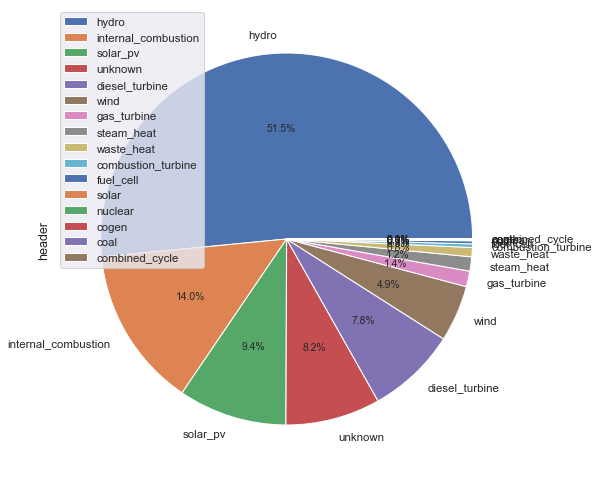

In [515]:
for_chart.header.value_counts().plot(kind='pie', figsize=(8,16), legend=True, autopct='%1.1f%%',
                                    )#explode=(0.05,0.05,0.05,0.05,0.05,0.05,0.05,0.05,0.05,0.05,0.05,0.05, 0.05, 0.05))

In [24]:
assigned_headers_drop.to_excel('/Users/aesharpe/Desktop/small_gens_with_headers.xlsx')

# Hydro Table
check to see if there is duplicate reporting between the tables

In [56]:
hydro = pudl_out.plants_hydro_ferc1() #.plant_type.unique()
pumped_storage = pudl_out.plants_pumped_storage_ferc1()

# This shows that all plants with the name none also have no important information in them
test = hydro.query("plant_name_ferc1=='none'").copy()
test = test.replace({0: np.nan, 'unknown': np.nan})
cols = test.columns[6:37]
test[cols].value_counts()

Series([], dtype: int64)

In [15]:
hydro.plant_type.unique()
hydro[hydro['plant_name_ferc1'].str.contains('total')]
hydro[hydro['utility_id_ferc1']==195]
pumped_storage[pumped_storage['plant_name_ferc1'].str.contains('total')]
pumped_storage.query('utility_id_pudl==81')

,report_year,utility_id_ferc1,utility_id_pudl,utility_name_ferc1,plant_name_ferc1,record_id,asset_retirement_cost,avg_num_employees,capacity_mw,capex_equipment_electric,capex_equipment_misc,capex_facilities,capex_land,capex_per_mw,capex_roads,capex_structures,capex_total,capex_wheels_turbines_generators,construction_type,construction_year,energy_used_for_pumping_mwh,installation_year,net_generation_mwh,net_load_mwh,opex_dams,opex_electric,opex_engineering,opex_generation_misc,opex_misc_plant,opex_operations,opex_per_mwh,opex_plant,opex_production_before_pumping,opex_pumped_storage,opex_pumping,opex_rents,opex_structures,opex_total,opex_water_for_power,peak_demand_mw,plant_capability_mw,plant_hours_connected_while_generating,plant_id_pudl,project_num
297,1994,41,81,Consumers Energy Company,ludington,f1_pumped_storage_1994_12_41_0_1,NaN,36.0,1978.80,11575560.0,2962710.0,211329133.0,4932750.0,1.690821e+05,3398333.0,35526549.0,334579685.0,64854650.0,conventional,1973.0,2764973.0,1973.0,1953910.0,-811063.0,NaN,NaN,NaN,NaN,NaN,NaN,0.000000e+00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1633.0,1872.0,3411.0,887,2680
298,1994,41,81,Consumers Energy Company,ludington,f1_pumped_storage_1994_12_41_0_2,NaN,NaN,1009.20,5240616.0,1396736.0,96259576.0,2490599.0,1.526829e+05,1535548.0,16121287.0,154087596.0,31043234.0,conventional,1973.0,1410138.0,1973.0,996494.0,-413644.0,2384357.0,400209.0,13657.0,532317.0,113376.0,340612.0,2.670000e+01,2461155.0,7097341.0,NaN,19511545.0,4360.0,87707.0,26608886.0,759591.0,826.0,955.0,NaN,887,2680
404,1995,41,81,Consumers Energy Company,ludington (total),f1_pumped_storage_1995_12_41_0_1,NaN,35.0,1978.80,69878169.0,11575560.0,35526549.0,NaN,3.397448e+11,3046965.0,4932749.0,3398333.0,211386474.0,conventional,1973.0,2559699.0,1973.0,1827879.0,-731820.0,NaN,NaN,NaN,NaN,NaN,172.0,0.000000e+00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1470.0,1872.0,3306.0,887,2680
405,1996,41,81,Consumers Energy Company,ludington (total),f1_pumped_storage_1996_12_41_0_1,NaN,36.0,1978.80,11601745.0,3059367.0,211386474.0,5019465.0,1.743296e+05,3398333.0,35526549.0,344963432.0,74971499.0,conventional,1973.0,2876249.0,1973.0,2055913.0,-820336.0,NaN,NaN,NaN,NaN,NaN,NaN,0.000000e+00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1664.0,1872.0,3523.0,887,2680
406,1997,41,81,Consumers Energy Company,ludington (total),f1_pumped_storage_1997_12_41_0_1,NaN,35.0,1978.80,11601745.0,3558642.0,212604643.0,4976966.0,1.745721e+05,3398333.0,35154417.0,345443273.0,74148527.0,conventional,1973.0,3278358.0,1973.0,2343973.0,-934385.0,NaN,NaN,NaN,NaN,NaN,NaN,0.000000e+00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1844.0,1872.0,4324.0,887,2680
407,1998,41,81,Consumers Energy Company,ludington (total),f1_pumped_storage_1998_12_41_0_1,NaN,36.0,1978.80,11601745.0,3594809.0,212627647.0,4872559.0,1.745427e+05,3398333.0,35141420.0,345385040.0,74148527.0,conventional,1973.0,3382323.0,1973.0,2441964.0,-940359.0,NaN,NaN,NaN,NaN,NaN,NaN,0.000000e+00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1740.0,1872.0,3819.0,887,2680
408,1999,41,81,Consumers Energy Company,ludington (total),f1_pumped_storage_1999_12_41_0_1,NaN,36.0,1978.80,11601745.0,3650351.0,212628136.0,4872559.0,1.763232e+05,3398333.0,35193577.0,348908404.0,77563703.0,conventional,1973.0,3322651.0,1973.0,2390177.0,-932474.0,NaN,NaN,NaN,NaN,NaN,NaN,0.000000e+00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1896.0,1872.0,3875.0,887,2680
409,2000,41,81,Consumers Energy Company,ludington (total),f1_pumped_storage_2000_12_41_0_1,NaN,36.0,1978.80,11601745.0,3658901.0,212628136.0,4872559.0,1.756418e+05,3398333.0,35193577.0,347559979.0,76206728.0,conventional,1973.0,3801978.0,1973.0,2742280.0,-1059698.0,NaN,NaN,NaN,NaN,NaN,NaN,0.000000e+00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1849.0,1872.0,4166.0,887,2680
410,2001,41,81,Consumers Energy Company,ludington (total),f1_pumped_storage_2001_12_41_0_1,NaN,38.0,1978.80,18408165.0,3668988.0,212628136.0,4872559.0,1.792234e+05,3398333.0,35464308.0,354647217.0,76206728.0,conventional,1973.0,4010996.0,1973.0,2884159.0,-1126837.0,NaN,NaN,NaN,NaN,NaN,NaN,

In [19]:
pudl_out.plants_pumped_storage_ferc1().columns.tolist()

['report_year',
 'utility_id_ferc1',
 'utility_id_pudl',
 'utility_name_ferc1',
 'plant_name_ferc1',
 'record_id',
 'asset_retirement_cost',
 'avg_num_employees',
 'capacity_mw',
 'capex_equipment_electric',
 'capex_equipment_misc',
 'capex_facilities',
 'capex_land',
 'capex_per_mw',
 'capex_roads',
 'capex_structures',
 'capex_total',
 'capex_wheels_turbines_generators',
 'construction_type',
 'construction_year',
 'energy_used_for_pumping_mwh',
 'installation_year',
 'net_generation_mwh',
 'net_load_mwh',
 'opex_dams',
 'opex_electric',
 'opex_engineering',
 'opex_generation_misc',
 'opex_misc_plant',
 'opex_operations',
 'opex_per_mwh',
 'opex_plant',
 'opex_production_before_pumping',
 'opex_pumped_storage',
 'opex_pumping',
 'opex_rents',
 'opex_structures',
 'opex_total',
 'opex_water_for_power',
 'peak_demand_mw',
 'plant_capability_mw',
 'plant_hours_connected_while_generating',
 'plant_id_pudl',
 'project_num']

In [59]:
eia = pudl_out.gens_eia860()
eia.technology_description.unique().tolist()

KeyboardInterrupt: 

In [69]:
eia[eia['technology_description']=='Hydrokinetic']

,report_date,plant_id_eia,plant_id_pudl,plant_name_eia,utility_id_eia,utility_id_pudl,utility_name_eia,generator_id,associated_combined_heat_power,balancing_authority_code_eia,balancing_authority_name_eia,bypass_heat_recovery,capacity_mw,carbon_capture,city,cofire_fuels,county,current_planned_operating_date,data_source,deliver_power_transgrid,distributed_generation,duct_burners,energy_source_1_transport_1,energy_source_1_transport_2,energy_source_1_transport_3,energy_source_2_transport_1,energy_source_2_transport_2,energy_source_2_transport_3,energy_source_code_1,energy_source_code_2,energy_source_code_3,energy_source_code_4,energy_source_code_5,energy_source_code_6,ferc_cogen_status,ferc_exempt_wholesale_generator,ferc_small_power_producer,fluidized_bed_tech,fuel_type_code_pudl,fuel_type_count,grid_voltage_2_kv,grid_voltage_3_kv,grid_voltage_kv,iso_rto_code,latitude,longitude,minimum_load_mw,multiple_fuels,nameplate_power_factor,operating_date,...,planned_energy_source_code_1,planned_modifications,planned_net_summer_capacity_derate_mw,planned_net_summer_capacity_uprate_mw,planned_net_winter_capacity_derate_mw,planned_net_winter_capacity_uprate_mw,planned_new_capacity_mw,planned_new_prime_mover_code,planned_repower_date,planned_retirement_date,planned_uprate_date,previously_canceled,primary_purpose_naics_id,prime_mover_code,pulverized_coal_tech,reactive_power_output_mvar,retirement_date,rto_iso_lmp_node_id,rto_iso_location_wholesale_reporting_id,sector_id,sector_name,service_area,solid_fuel_gasification,startup_source_code_1,startup_source_code_2,startup_source_code_3,startup_source_code_4,state,stoker_tech,street_address,subcritical_tech,summer_capacity_estimate,summer_capacity_mw,summer_estimated_capability_mw,supercritical_tech,switch_oil_gas,syncronized_transmission_grid,technology_description,time_cold_shutdown_full_load_code,timezone,topping_bottoming_code,turbines_inverters_hydrokinetics,turbines_num,ultrasupercritical_tech,uprate_derate_completed_date,uprate_derate_during_year,winter_capacity_estimate,winter_capacity_mw,winter_estimated_capability_mw,zip_code
136165,2014-01-01,59073,7000,Cove Point LNG Terminal,58889,1495,"Dominion Cove Point LNG, LP",5501,False,PJM,"PJM Interconnection, LLC",False,3.0,None,Lusby,None,Calvert,2017-03-01,eia860,None,None,False,None,None,None,None,None,None,WAT,None,None,None,None,None,False,False,False,None,hydro,4,NaN,NaN,12.47,None,38.385456,-76.409796,NaN,None,NaN,2018-04-01,...,None,None,NaN,NaN,NaN,NaN,NaN,None,None,None,None,False,486.0,OT,None,NaN,None,None,None,4.0,Commercial Non-CHP,None,False,None,None,None,None,MD,None,2100 Cove Point RD,None,None,3.0,NaN,None,None,False,Hydrokinetic,None,America/New_York,X,None,NaN,None,None,None,None,3.0,NaN,20657
136164,2014-01-01,59073,7000,Cove Point LNG Terminal,58889,1495,"Dominion Cove Point LNG, LP",5502,False,PJM,"PJM Interconnection, LLC",False,1.3,None,Lusby,None,Calvert,2017-03-01,eia860,None,None,False,None,None,None,None,None,None,WAT,None,None,None,None,None,False,False,False,None,hydro,4,NaN,NaN,12.47,None,38.385456,-76.409796,NaN,None,NaN,2018-04-01,...,None,None,NaN,NaN,NaN,NaN,NaN,None,None,None,None,False,486.0,OT,None,NaN,None,None,None,4.0,Commercial Non-CHP,None,False,None,None,None,None,MD,None,2100 Cove Point RD,None,None,1.3,NaN,None,None,False,Hydrokinetic,None,America/New_York,X,None,NaN,None,None,None,None,1.3,NaN,20657
136163,2014-01-01,59073,7000,Cove Point LNG Terminal,58889,1495,"Dominion Cove Point LNG, LP",5511,False,PJM,"PJM Interconnection, LLC",False,1.7,None,Lusby,None,Calvert,2017-03-01,eia860,None,None,False,None,None,None,None,None,None,WAT,None,None,None,None,None,False,False,False,None,hydro,4,NaN,NaN,12.47,None,38.385456,-76.409796,NaN,None,NaN,2018-04-01,...,None,None,NaN,NaN,NaN,NaN,NaN,None,None,None,None,False,486.0,OT,None,NaN,None,None,None,4.0,Commercial Non-CHP,None,False,None,None,None,None,MD,None,2100 Cove Point RD,None,None,1.7,NaN,None,None,False,Hydrokinetic,None,America/New_York,X,N

In [33]:
hydro[hydro['plant_name_ferc1'].str.contains('none')]

,report_year,utility_id_ferc1,utility_id_pudl,utility_name_ferc1,plant_name_ferc1,record_id,asset_retirement_cost,avg_num_employees,capacity_mw,capex_equipment,capex_facilities,capex_land,capex_per_mw,capex_roads,capex_structures,capex_total,construction_type,construction_year,installation_year,net_capacity_adverse_conditions_mw,net_capacity_favorable_conditions_mw,net_generation_mwh,opex_dams,opex_electric,opex_engineering,opex_generation_misc,opex_hydraulic,opex_misc_plant,opex_operations,opex_per_mwh,opex_plant,opex_rents,opex_structures,opex_total,opex_water_for_power,peak_demand_mw,plant_hours_connected_while_generating,plant_id_pudl,plant_type,project_num
2630,1994,180,338,UNITIL Power Corp.,none,f1_hydro_1994_12_180_0_1,NaN,NaN,0.0,NaN,NaN,NaN,0.0,NaN,NaN,NaN,unknown,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,9219,None,0
3113,1994,29,64,CITIZENS COMMUNCIATIONS COMPANY,none,f1_hydro_1994_12_29_0_1,NaN,NaN,0.0,NaN,NaN,NaN,0.0,NaN,NaN,NaN,unknown,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,11645,None,0
4674,1995,168,309,Susquehanna Electric Company,none,f1_hydro_1995_12_168_0_3,NaN,NaN,0.0,NaN,NaN,NaN,0.0,NaN,NaN,NaN,unknown,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,12197,None,0
4675,1996,168,309,Susquehanna Electric Company,none,f1_hydro_1996_12_168_0_3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,unknown,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,12197,None,0
4676,1997,168,309,Susquehanna Electric Company,none,f1_hydro_1997_12_168_0_3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,unknown,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,12197,None,0
4677,1998,168,309,Susquehanna Electric Company,none,f1_hydro_1998_12_168_0_3,NaN,NaN,0.0,NaN,NaN,NaN,0.0,NaN,NaN,NaN,unknown,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,12197,None,0
4678,1999,168,309,Susquehanna Electric Company,none,f1_hydro_1999_12_168_0_3,NaN,NaN,0.0,NaN,NaN,NaN,0.0,NaN,NaN,NaN,unknown,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,12197,None,0
4679,2000,168,309,Susquehanna Electric Company,none,f1_hydro_2000_12_168_0_3,NaN,NaN,0.0,NaN,NaN,NaN,0.0,NaN,NaN,NaN,unknown,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,12197,None,0
4680,2001,168,309,Susquehanna Electric Company,none,f1_hydro_2001_12_168_0_3,NaN,NaN,0.0,NaN,NaN,NaN,0.0,NaN,NaN,NaN,unknown,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,12197,None,0
4681,2002,168,309,Susquehanna Electric Company,none,f1_hydro_2002_12_168_0_3,NaN,NaN,0.0,NaN,NaN,NaN,0.0,NaN,NaN,NaN,unknown,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,12197,None,0


In [48]:
hydro.plant_type.unique()
hydro[hydro['plant_type']=='Storage'].head()
hydro[hydro['utility_id_ferc1']==2].query("report_year==1994")
#hydro.insert(5, 'tech', hydro['plant_type'])
hydro.insert(6, 'type', hydro['construction_type'])

In [53]:
hydro[hydro['utility_id_ferc1']==2].query("report_year==1994")
hydro.type.unique()
hydro[hydro['type']=='semioutdoor']

,report_year,utility_id_ferc1,utility_id_pudl,utility_name_ferc1,plant_name_ferc1,tech,type,record_id,asset_retirement_cost,avg_num_employees,capacity_mw,capex_equipment,capex_facilities,capex_land,capex_per_mw,capex_roads,capex_structures,capex_total,construction_type,construction_year,installation_year,net_capacity_adverse_conditions_mw,net_capacity_favorable_conditions_mw,net_generation_mwh,opex_dams,opex_electric,opex_engineering,opex_generation_misc,opex_hydraulic,opex_misc_plant,opex_operations,opex_per_mwh,opex_plant,opex_rents,opex_structures,opex_total,opex_water_for_power,peak_demand_mw,plant_hours_connected_while_generating,plant_id_pudl,plant_type,project_num
926,1995,102,192,"Montana Power Company, The",cochrane,Run-of-River,semioutdoor,f1_hydro_1995_12_102_0_2,NaN,NaN,60.0,3999681.0,5713042.0,63375.0,181379.5,93874.0,1012799.0,10882771.0,semioutdoor,1958.0,1958.0,30.0,55.0,335520.100,7826.0,112642.0,17913.0,13956.0,18162.0,8952.0,101875.0,1.1,42149.0,NaN,3051.0,379812.0,53286.0,56.0,8755.0,962,Run-of-River,2188
927,1996,102,192,"Montana Power Company, The",cochrane,Run-of-River,semioutdoor,f1_hydro_1996_12_102_0_2,NaN,NaN,48.0,4814764.0,5713042.0,63376.0,244769.5,93874.0,1063881.0,11748937.0,semioutdoor,1958.0,1958.0,18.0,54.0,343907.900,44602.0,96503.0,12534.0,12912.0,19818.0,29130.0,88351.0,1.2,36560.0,NaN,6697.0,414941.0,67834.0,55.0,8758.0,962,Run-of-River,2188
928,1997,102,192,"Montana Power Company, The",cochrane,Run-of-River,semioutdoor,f1_hydro_1997_12_102_0_2,NaN,NaN,48.0,4814764.0,5713042.0,63376.0,244769.5,93874.0,1063881.0,11748937.0,semioutdoor,1958.0,1958.0,18.0,54.0,395102.300,24003.0,126019.0,14995.0,17502.0,33913.0,5661.0,102610.0,1.1,36985.0,24.0,3385.0,456866.0,91769.0,57.0,8755.0,962,Run-of-River,2188
929,1998,102,192,"Montana Power Company, The",cochrane,Run-of-River,semioutdoor,f1_hydro_1998_12_102_0_2,NaN,NaN,48.0,4827410.0,5715657.0,63376.0,245795.8,93873.0,1097881.0,11798197.0,semioutdoor,1958.0,1958.0,18.0,54.0,337795.200,20228.0,161458.0,21525.0,12375.0,57258.0,14632.0,129343.0,1.6,48032.0,NaN,41951.0,551202.0,44400.0,55.0,8757.0,962,Run-of-River,2188
930,1999,102,192,"Montana Power Company, The",cochrane,Run-of-River,semioutdoor,f1_hydro_1999_12_102_0_2,NaN,NaN,48.0,NaN,NaN,NaN,0.0,NaN,NaN,NaN,semioutdoor,1958.0,1958.0,18.0,54.0,317058.369,10987.0,140906.0,16175.0,16346.0,8124.0,4889.0,92692.0,1.1,23253.0,NaN,1048.0,359825.0,45405.0,55.0,8741.0,962,Run-of-River,2188
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6470,2015,122,226,NorthWestern Corporation,morony,Run-of-River,semioutdoor,f1_hydro_2015_12_122_1_1,NaN,4.0,48.0,31217712.0,3781975.0,183300.0,747255.3,3930.0,681339.0,35868256.0,semioutdoor,1930.0,1930.0,17.0,48.0,247097.000,5875.0,79215.0,77406.0,28941.0,309739.0,58788.0,83129.0,3.9,157744.0,NaN,62625.0,967271.0,103809.0,48.0,8760.0,958,Run-of-River,2188
6471,2016,122,226,NorthWestern Corporation,morony,Run-of-River,semioutdoor,f1_hydro_2016_12_122_1_1,NaN,4.0,48.0,31217712.0,3781975.0,183300.0,747255.3,3930.0,681339.0,35868256.0,semioutdoor,1930.0,1930.0,17.0,48.0,258995.000,204297.0,146419.0,NaN,11853.0,23944.0,87887.0,NaN,2.9,67819.0,NaN,53651.0,746657.0,150787.0,48.0,8760.0,958,Run-of-River,2188
6472,2017,122,226,NorthWestern Corporation,morony,Run-of-River,semioutdoor,f1_hydro_2017_12_122_1_1,NaN,4.0,48.0,31217712.0,3781975.0,183300.0,747255.3,3930.0,681339.0,35868256.0,semioutdoor,1930.0,1930.0,17.0,48.0,289766.000,17101.0,153773.0,NaN,9988.0,NaN,9257.0,314.0,1.3,56409.0,NaN,23811.0,384599.0,113946.0,48.0,8760.0,958,Run-of-River,2188
6473,2018,122,226,NorthWestern Corporation,morony,Run-of-River,semioutdoor,f1_hydro_2018_12_122_1_1,NaN,4.0,46.5,31489720.0,3781975.0,183300.0,777210.0,3930.0,681339.0,36140264.0,semioutdoor,1930.0,1930.0,10.0,49.0,323972.000,9623.0,182762.0,NaN,12221.0,190.0,4802.0,339.0,1.1,37977.0,NaN,7936.0,360874.0,105024.0,49.0,

NameError: name 'eia' is not defined